<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/meerkat_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meerkat Preprocessing

In this script, I am preprocessing audio data so that I can reproduce the unsupervised clustering analysis performed by Gentner et al. 2019 (https://www.biorxiv.org/content/10.1101/870311v1.full.pdf) with meerkat vocalizations. I am planning to use the functions made available by Tim Sainsberg (https://github.com/timsainb/avgn_paper), a package called AVGN that should allow me to reproduce the analyses in the paper. Therefore, I need to bring my data into the format that is necessary to run the AVGN analysis functions.

Thus, the aim of this script is to generate four types of files: 
- fileID_call[number].WAV files, each containing a meerkat call
- fileID_noise[number].WAV files, each containing noise recorded prior or after a meerkat call
- fileID_call[number].json files, each containing the metadata for a meerkat call
- fileID_label.csv files

The input to this script are long audio files usually containing up to 300 calls and csv files containing the start and stop times and labels of meerkat calls as annotated manually.

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH
- Project folder must contain subfolder called "in_labels", containing all label tables in csv format 
- Project folder must contain subfolder called "in_wavs", containing all audio files

### Mounting drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Or select "Mount Drive" in Files menu!

### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [1]:
import os
os.system('pip install pydub') # need to install
import pandas as pd
import sys
import re
import json
from IPython.display import Audio 
os.system('pip install "librosa==0.7.1"')
import librosa
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install noisereduce') # need to install
import noisereduce as nr
os.system('pip install pathlib2') # need to install
import pathlib2

/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Setting constants

Setting project, input and output folders.

In [0]:
# these directories should already exist
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
AUDIO_IN = PROJECT_PATH+"in_wavs/" 
LABELS_IN = PROJECT_PATH+"in_labels/" 

# these directories are created during execution
AUDIO_OUT = PROJECT_PATH+"segmented_audios/" 
LABELS_OUT = PROJECT_PATH+"labels/"
JSON_OUT = PROJECT_PATH+'json_files/'
NOISE_OUT = PROJECT_PATH+'noise_files/'

dirs2create = [AUDIO_OUT, LABELS_OUT, JSON_OUT, NOISE_OUT]

noise_params = {
    "min_noise_ms": 1000,
    "max_noise_ms": 2000
}

Constants for parsing label files:

- column names in labels CSV that indicate start and duration
- irrelevant labels that are discarded in the process (labels for beeps, noise, synch calls..)
- minimum call duration in ms

In [0]:
START_COL = 'Start'
DUR_COL = 'Duration'

IRRELEVANT_LABELS = ['SYNCH', 'START', 'END', 'NOISE', 'BEEP', 'CHEW']
IRRELEVANT_LABELS = IRRELEVANT_LABELS+[item.lower() for item in IRRELEVANT_LABELS]

MIN_DURATION = 100 
GROUP = 'HM'

### Installing AVGN

Cloning the AVGN_paper repository:

In [6]:
os.chdir(PROJECT_PATH)

if (not os.path.exists(PROJECT_PATH+'avgn_paper')):
  print("Cloning Repo")
  os.mkdir("avgn_paper")
  os.chdir("avgn_paper")
  os.sytem('git clone https://github.com/timsainb/avgn_paper.git')
else:
  print("Repo already present")
  os.chdir("avgn_paper")

Repo already present


In [7]:
os.system('python setup.py develop')

0

In [0]:
from importlib.machinery import SourceFileLoader
#avgn = SourceFileLoader('avgnpaper/avgn', join(PROJECT_PATH, 'utils/somelib.py')).load_module()
avgn = SourceFileLoader('avgnpaper/avgn', PROJECT_PATH+'avgn_paper/avgn/'+'utils/__init__.py').load_module()
import avgn

### Loading AVGN libraries

For some parts of the preprocessing script, I use the original functions from Sainsberg:

In [0]:
# JSON generation
from avgn.utils.json import NoIndent, NoIndentEncoder, read_json

# spectrogramming
from avgn.utils.hparams import HParams 
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio
from avgn.signalprocessing.filtering import butter_bandpass_filter 
from tqdm.autonotebook import tqdm
from avgn.visualization.spectrogram import draw_spec_set


### Creating output directories

In [0]:
os.chdir(PROJECT_PATH)

for dirpath in dirs2create:
  if not os.path.exists(os.path.basename(dirpath[:-1])):
    os.mkdir(os.path.basename(dirpath[:-1]))

## Functions

What I need are short .wav files, each containing one single vocalization of a meerkat. What I have are long .wav files, containing many vocalizations and periods of silence (noise), and a label file (CSV) indicating at what time vocalisations occur (and what type of vocalisation they are). In addition, I need a JSON metadata file for each vocalization .wav file.

In [0]:
os.chdir(PROJECT_PATH)

### General

In [0]:
# Function that gets fileID from csv filename
# Input: csv_filename (not path!) (String)
# Output: csv_filename up to the last numeric character

def fileID_from_csv_filename(csv_in):
  csv_in = csv_in[::-1]  # reverse string
  def rem_nonnumeric(str): # removes everything up to the first numeric char
    foundDigit=False
    pos=0
    for char in str:
      if(char.isdigit()):
        return(str[pos:])
      pos=pos+1
    return str 
  csv_out = rem_nonnumeric(csv_in)
  csv_out = csv_out[::-1] # reverse to normal again
  return (csv_out)

### Functions for parsing label files

First, I'll parse the csv label files into a pandas dataframe. Then, because PyDub segments audio in milliseconds, I have to turn the format h:min:s.ms to ms, so that I have the start and stop times of the calls in milliseconds (f.e. 10032002-10032144)

In [0]:
# Function that gets datatime object from timestring
# timestring must match one of the given time_patterns
# Input: some string containing a time (String)
# Output: datetime object
# Example usage: dt = get_time("01:02:30.555")
def get_time(timestring):
    time_patterns = ['%H:%M:%S.%f', '%M:%S.%f']
    for pattern in time_patterns:
        try:
            return datetime.strptime(timestring, pattern)
        except:
            pass

    print("Date is not in expected format")
    sys.exit(0)

# Function that converts time in datatime object to ms 
# Input: datatime (datatime.datatime)
# Output: time in ms (float)
# Example usage: ms = get_ms(datatime_obj)
def get_ms(dt):
    return dt.microsecond/1000+dt.second*1000 + dt.minute*60*1000 + dt.hour*60*60*1000


In [0]:
# Function that generates labels dataframe from csv file
# - adds start and stop times of calls in milliseconds
# - removes irrelevant labelled sections (noise, synch, beep etc.)
# - removes labelled sections below minimum duration
# Input: filepath to label csv (String)
# Output: pandas dataframe, each row representing one call
# Example usage: labels = parse_labels(label_filepath)

def prep_labels(label_filepath):
  print("Parsing...")
  # read in labels
  labels = pd.read_csv(label_filepath, sep="\t")
  
  # Remove irrelevant labels
  # find name of column that contains the labels. Should contain 'Name'
  name_col = [col for col in labels.columns if 'Name' in col]
  # hopefully only one result
  if(len(name_col)==1):
    name_col = name_col[0]
    labels = labels[~labels[name_col].str.contains('|'.join(IRRELEVANT_LABELS))]
  else:
    print("Cannot find label name column")
  
  # Add start stop ms
  if (labels.shape[0]!=0):
    labels['start_ms'] = labels.apply(lambda row: get_ms(get_time(row['Start'])), axis=1)
    labels['duration_ms'] = labels.apply(lambda row: get_ms(get_time(row['Duration'])), axis=1)
    labels['stop_ms'] = labels['start_ms']+labels['duration_ms']

    # Remove super short calls (possibly mistakes?)
    labels = labels.loc[labels['duration_ms'] >= MIN_DURATION]
  
  return labels

### Functions for segmenting audio files

I'll segment the audio files based on the timings given in the label files.

In [0]:
# Function that generates audio chunks based on a label file that
# provides start and stop times in ms
# Input: filepath to audiofile (.wav) (String), 
#        filepath to labelsfile (.csv) (String)
# Output: None, audio chunks are exported in current working directory, named
#         filename_call_[number].wav (numbered 1,2,3...)
# Example usage: generate_audio_chunks(audio_filepath, label_filepath)

def generate_audio_chunks(audio_filepath, label_filepath):
  
  print("Processing "+os.path.basename(audio_filepath))

  # Parse labels
  labels = prep_labels(label_filepath)
  
  # If labels is non-empty...
  if (labels.shape[0]!=0):
    # Create audio chunks based on start and stop ms 
    print("Chunking...")
    audio_filename = os.path.basename(audio_filepath)
    audio = AudioSegment.from_wav(audio_filepath)
    chunks = labels.apply(lambda row: (audio[row['start_ms']:row['stop_ms']]), axis = 1)

    # export chunks in current working directory
    chunks.index=range(chunks.shape[0])
    for index, content in chunks.items():
      content.export((audio_filename[:-4]+"_call"+str(index)+".wav"), format="wav")
  
  # save modified labels file
    labels['audio_file'] = [audio_filename[:-4]+"_call"+str(i)+".wav" for i in range(labels.shape[0])]
    labels.to_csv(LABELS_OUT+audio_filename[:-4]+"_labels.csv")

  else:
    print("No labelled calls for "+os.path.basename(audio_filepath))

### Functions for generating noise files

In [0]:
# Function to generate noise file for a call wav
# Input: filepath to call wav (String), 
#        filepath to full wav (String), 
#        filepath to label csv (String),
#        fileID (String), 
#        Parameters for generating noise file (Dict)
# Output: returns file name of noise wav file or NA (String), 
#         generates noise file in NOISE_OUT directory
# Comments: - uses subfunctions extract_noise_pre and extract_noise_post
#           - adapted from Sainsberg

def generate_noisewav(call_filepath, wav_filepath, label_filepath, fileID, noise_params):

  noise_file = "NA"  
  call_filename = os.path.basename(call_filepath)
  # not pretty but should work to get the call number
  # [:-4] to remove .wav, split _call to get number behind _call
  # (could also take row number of label table)
  call_num = call_filename[:-4].split("_call")[1]
  label_table = pd.read_csv(label_filepath)

  # these need to be converted to seconds
  call_start = label_table.loc[label_table['audio_file']==call_filename, 'start_ms'].values[0]/1000
  call_end = label_table.loc[label_table['audio_file']==call_filename, 'stop_ms'].values[0]/1000
  
  min_noise_size = noise_params["min_noise_ms"]/1000
  max_noise_size = noise_params["max_noise_ms"]/1000

  all_call_ends = np.asarray(label_table['stop_ms'])/1000

  # try to get noise from pre call
  noise_clip, sr = extract_noise_pre(call_start, call_end, wav_filepath, all_call_ends, min_noise_size, max_noise_size)
  if noise_clip is None:
    # try to get noise from post call
    all_call_starts = np.asarray(label_table['start_ms'])/1000
    noise_clip, sr = extract_noise_post(call_start, call_end, wav_filepath, all_call_starts, min_noise_size, max_noise_size)
  
  # save noise file (if one could be generated)
  if noise_clip is not None:
    librosa.output.write_wav(NOISE_OUT+fileID+'_noise'+call_num+'.wav', y=noise_clip, sr=sr, norm=True)
    noise_file = fileID+'_noise'+call_num+'.wav'

  return noise_file


def extract_noise_pre(call_start, call_end, wav_filepath, all_call_ends, min_noise_size, max_noise_size):
  # try to get a noise clip from the time preceding this clip
  if call_start > min_noise_size:
    # get time of preceding pulses
    td = call_start - all_call_ends
    td = td[td > 0]
    # if there is anything within this timeframe, this timeframe is unusable
    if not np.any(td < min_noise_size):
      # get times for noise clip
      noise_start = call_start - np.min(
          list(td - 1) + [max_noise_size]
          )
      noise_end = call_start

      # load the clip
      noise_clip, sr = librosa.load(
          wav_filepath,
          mono=True,
          sr=None,
          offset=noise_start,
          duration=(noise_end - noise_start),
          )
      return noise_clip, sr
  return None, None


def extract_noise_post(call_start, call_end, wav_filepath, all_call_starts, min_noise_size, max_noise_size):
  # try to get noise clip from end of file
  wav_duration = (librosa.get_duration(filename=wav_filepath))
  if wav_duration - call_end > min_noise_size:
    td = all_call_starts - call_end
    td = td[td > 0]
    if not np.any(td < min_noise_size):
      # get times for noise clip
      noise_start = call_end
      noise_end = call_end + np.min(
          list(td - min_noise_size / 2)
          + [max_noise_size]
          )
      # load the clip
      noise_clip, sr = librosa.load(
          wav_filepath,
          mono=True,
          sr=None,
          offset=noise_start,
          duration=(noise_end - noise_start),
          )
      return noise_clip, sr
  return None, None


### Functions for generating JSON files

In [0]:
# Function to get the meerkat ID (alphanumeric String) from filename
# filename is always HM_meerkatID_*.extension
# Input: filename (String)
# Output: meerkat ID (String)
# Example use: get_meerkatID('HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102.wav')

def get_meerkatID(filename):
  meerkatID = filename.replace(GROUP+'_','')
  meerkatID = str.split(meerkatID, sep='_')[0]
  return meerkatID

# Function to get date from filename
# date in filename must be in one of the three patterns
# Input: filename (String)
# Output: datetime object
# Example use: get_datetime('HM_VHMF001_HTB_R20_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944')

def get_datetime(filename):
  import re, datetime
  s = "I have a meeting on 2018-12-10 in New York"
  match = re.search('\d{4}-\d{2}-\d{2}', filename)
  if (match):
    date = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
  else:
    match = re.search('\d{4}_\d{2}_\d{2}', filename)
    if (match):
     date = datetime.datetime.strptime(match.group(), '%Y_%m_%d').date() 
    else:
      match = re.search('\d{4}\d{2}\d{2}', filename)
      if(match):
        date = datetime.datetime.strptime(match.group(), '%Y%m%d').date()
  return date

# TODO
# Function to generate JSON file for call wav
# Input: filepath to call wav (String), filepath to full wav (String), filepath to label csv (String), 
# Output: location of JSON file, generates JSON files in JSON_OUT directory
# adapted from AVGN
def generate_json(call_filepath, wav_filepath, label_filepath, fileID, noise_wav):

  wav_date, sr, wav_duration, bout_number, indv, json_out, call_label= "NA", "NA", "NA", "NA", "NA", "NA", "NA"
  
  wav_date = get_datetime(fileID).strftime("%Y-%m-%d")
  wav_duration = librosa.get_duration(filename=call_filepath)
  #y,sr = librosa.load(call_filepath) #get_samplerate doesn't work with librosa 0.6
  sr = librosa.get_samplerate(call_filepath)
  bout_number = int(os.path.basename(call_filepath)[:-4].split('_call')[1])
  indv = get_meerkatID(fileID)

  # Call label
  label_table=pd.read_csv(label_loc)

    
  # wav general information
  json_dict = {}
  json_dict["datetime"] = wav_date
  json_dict["samplerate_hz"] = sr
  json_dict["length_s"] = wav_duration
  json_dict["species"] = "Suricata suricatta"
  json_dict["common_name"] = "Meerkat"
  json_dict["wav_loc"] = call_filepath
  json_dict["bout_number"] = bout_number
  json_dict["original_wav"] = wav_filepath
  json_dict["noise_loc"] = noise_wav
  json_dict["indv"] = indv
  json_dict["label"] = label_table.loc[bout_number,'Name']
  json_dict["start_s"] = label_table.loc[bout_number,'start_ms']/1000
  json_dict["stop_s"] = label_table.loc[bout_number,'stop_ms']/1000
  json_dict["Type"] = label_table.loc[bout_number,'Type']
    
  json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
  json_out = JSON_OUT+(os.path.basename(call_filepath)[:-4]+".JSON")

  # save json
  print(json_txt, file=open(json_out, "w"))

  return json_out

### Functions for dataset dataframe generation

In [0]:
# Function that creates dataframe of all calls based on their JSON file
# Input: fileID (String)
# Output: Dataframe of all calls associated with that fileID (Dataframe)
# Example use: label_df = create_label_df('HM_VHMM023_MBLS_R02_20190707-20190719_file_10_(2019_07_16-11_44_59)_165944')

def create_label_df(fileID):   
    call_df = []
    json_files = glob.glob(JSON_OUT+fileID+'*')
    for json_file in json_files:
      json_dict = read_json(json_file)
      call_df.append(list(json_dict.values())+[os.path.basename(json_file)[:-5]])

    all_calls_df = pd.DataFrame(call_df, columns=list(json_dict.keys())+['key'])
    return all_calls_df

### Functions for creating spectrograms

In [0]:
# Function that applies filtering and noise reduction to audio data
# (if hparams.noise_reduce=True)
# Input: Audio Data (Amplitude) (numpy array) 
#        Audio parameters (Hparams, a custom AVGN object type)
# Output: Amplitude (numpy array)

def filter_audio(data, rate, noise_wav, hparams):
  # convert data if needed
  if np.issubdtype(type(data[0]), np.integer):
      data = int16_to_float32(data)
    # bandpass filter
  if hparams is not None:
      data = butter_bandpass_filter(
          data, hparams.butter_lowcut, hparams.butter_highcut, rate, order=5
          )

      if hparams.reduce_noise:
        if not noise_wav=="NA": 
          noise_data, noise_rate = librosa.load(noise_wav)
          data = nr.reduce_noise(audio_clip=data,
                                noise_clip=noise_data,
                                )

  return data

# Function that gets audio data (numpy array of amplitude) from wav
# Input: Path to wav file (String) 
#        Audio parameters (Hparams, a custom AVGN object type)
# Output: Amplitude (numpy array)

def get_audio(wav_loc, hparams):
  # get rate and date
  data, rate = librosa.load(wav_loc)
  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data

In [0]:
# Function that generates mel spectrogram from audio data
# Input: Audio data (np array of floats), 
#        samplerate in Hz (integer)
#        number of mel bands (integer)
#        spectrogram window generation type (String)
#        window length in s (float)
#        hop between window start in s (float)
# Output: Spectrogram (np array of floats)

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    win_length  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = rate/2, 
                                       n_fft = win_length,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = win_length)
    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro

## Processing files

### Setting variables

Getting list of csvs and matching wavs

In [0]:
# Getting list of fileIDs, wavs and csvs (fileID, in_wav_loc and in_csv_loc)

in_csv_loc = glob.glob(LABELS_IN+'*.csv') + glob.glob(LABELS_IN+'*.CSV')
csv_filenames = [os.path.basename(csv) for csv in in_csv_loc]

fileIDs = [fileID_from_csv_filename(csv_filename) for csv_filename in csv_filenames]

in_wav_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
in_wav_loc = [["NA"] if not x else x for x in in_wav_loc] # Replace empty lists with "NA"
in_wav_loc = list(flatten(in_wav_loc)) # Flatten list

For now, only use random subset

In [0]:
in_csv_loc = in_csv_loc[18:23]+in_csv_loc[50:55]+in_csv_loc[90:95]
in_wav_loc = in_wav_loc[18:23]+in_wav_loc[50:55]+in_wav_loc[90:95]

### Removing poor quality files

In [0]:
badIDs = ['HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163', 
           'HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052']

In [0]:
bad_csvs = [glob.glob(LABELS_IN+fileID+'*') for fileID in badIDs]
bad_csvs = list(flatten(bad_csvs))

bad_wavs = []
for bad_csv in bad_csvs:
  bad_wavs.append(in_wav_loc[in_csv_loc.index(bad_csv)])

for bad_csv in bad_csvs:
  in_csv_loc.remove(bad_csv)
for bad_wav in bad_wavs:
  in_wav_loc.remove(bad_wav)


### Segmenting audio files

Segmenting the audio files in AUDIO_IN into smaller chunks, each containing one call. Start and stop times of calls are taken from label files (csv) in LABELS_IN folder. 

generate_audio_chunks generates audio chunks based on a label file that provides start and stop times in ms. It takes a filepath to audiofile (.wav) (String) and a filepath to labelsfile (.csv) (String) as input. The output is none, but audio chunks are exported in AUDIO_OUT directory, named filename_call_[number].wav (numbered 1,2,3...)

In [0]:
os.chdir(AUDIO_OUT)

In [76]:
for wav, csv in zip(in_wav_loc, in_csv_loc):
  if not wav=='NA':
    generate_audio_chunks(wav, csv)
  else:
    print("No matching audio for: "+csv)

Processing HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092.wav
Parsing...
Chunking...
Processing HM_VHMM003_SOUNDFOC_20170824_2.WAV
Parsing...
Chunking...
Processing HM_HMB_R11_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221163.wav
Parsing...
Chunking...
No matching audio for: /content/drive/My Drive/meerkat/in_labels/HM_VHMM003_SOUNDFOC_20170905_4_label.csv
Processing HM_VLF206_SOUNDFOC_20170825_1.WAV
Parsing...
Chunking...
Processing HM_VCVM001_SOUNDFOC_20190712_1.WAV
Parsing...
Chunking...
Processing HM_VHMF019_MBTB_R25_20190707-20190719_file_8_(2019_07_14-11_44_59)_145944.wav
Parsing...
Chunking...
Processing HM_VHMF019_MBTB_R25_20190707-20190719_file_10_(2019_07_16-11_44_59)_165944.wav
Parsing...
Chunking...
Processing HM_VHMF022_MBRS_R22_20190707-20190719_file_6_(2019_07_12-11_44_59)_125944.wav
Parsing...
Chunking...
Processing HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944.wav
Parsing...
Chunking...
Processing HM_VHMF022_MBRS_R22_20

In [77]:
print("Generated "+str(len(glob.glob(LABELS_OUT+'*')))+" label files")
print("Generated "+str(len(glob.glob(AUDIO_OUT+'*')))+" audio chunks")

Generated 14 label files
Generated 2671 audio chunks


From processing most of the 2017 files:
(need to update this section later)

Segmented audios were generated for all files, except:

- files where all labels were something other than calls:
  - HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110 

- files where where there was no matching wav file:
  - HM_VHMM003_SOUNDFOC_20170905_2 (in short list)
  - HM_VLF206_SOUNDFOC_20170903
  - HM_VHMM003_SOUNDFOC_20170905_4 (in short list)
  - HM_VHMM003_SOUNDFOC_20170905_3
  - HM_VLF206_SOUNDFOC_20170905_2
  - HM_VLF206_SOUNDFOC_20170905_1



### Get updated list of wav and labels file locations

In [0]:
# List of all wav filepaths (to full wav files, not just the calls), where I have 
# a labels file in LABELS_OUT. Therefore, do it kind of backwards.

labels_loc = glob.glob(LABELS_OUT+'*.csv')
fileIDs = [os.path.basename(item).replace('_labels.csv', '') for item in labels_loc] 

wavs_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
wavs_loc = [["NA"] if not x else x for x in wavs_loc] # Replace empty lists with "NA"
wavs_loc = list(flatten(wavs_loc)) # Flatten list

# check for NAs, should be none!
for ID, wav in zip(fileIDs, wavs_loc):
  if wav=="NA":
    print("Error, wav file missing for"+label)


### Generating noise files

Generating the noise file (a wav of the 1-2s prior of after a call if not another call occurs in this time window). Can be used later to denoise the call wav. The noise files are saved in the NOISE_OUT folder and labelled: 
- fileID_noise[call_number].wav

A column 'noise_wav' is added to the fileIDlabels.csv containing either the noise filename or "NA" if no noise file could be generated.

In [0]:
os.chdir(PROJECT_PATH)

Noise file generation:

In [149]:
# for each long wav file
for wav_filepath, label_filepath, fileID in zip(wavs_loc, labels_loc, fileIDs):
  #fileID = os.path.basename(wav_filepath).replace('.wav', '')
  print("Generating noise files for "+fileID)
  # find the matching label file
  #label_filepath = glob.glob(LABELS_OUT+fileID+'*.csv')[0]
  # generate list of call wavs assigned to it
  call_filepathList = glob.glob(AUDIO_OUT+fileID+'*.wav')

  # Then:
  # for each call wav
  noise_wavs = []
  for call_filepath in call_filepathList:

    # generate NOISE file
    # append location of noise wav to noise_wavs list
    result = generate_noisewav(call_filepath, wav_filepath, label_filepath, fileID, noise_params)
    noise_wavs.append(result)
    #noise_wavs.append(generate_noisewav(call_filepath, wav_filepath, label_filepath, fileID, noise_params))
  
  # add noise_wav column to labels.csv files
  lable_table = pd.read_csv(label_filepath)
  lable_table['noise_wav'] = noise_wavs
  lable_table.to_csv(label_filepath)


Generating noise files for HM_VHMM003_SOUNDFOC_20170824_2
Generating noise files for HM_HMB_R11_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221163
Generating noise files for HM_VLF206_SOUNDFOC_20170825_1
Generating noise files for HM_VCVM001_SOUNDFOC_20190712_1
Generating noise files for HM_VHMF019_MBTB_R25_20190707-20190719_file_8_(2019_07_14-11_44_59)_145944
Generating noise files for HM_VHMF019_MBTB_R25_20190707-20190719_file_10_(2019_07_16-11_44_59)_165944
Generating noise files for HM_VHMF022_MBRS_R22_20190707-20190719_file_6_(2019_07_12-11_44_59)_125944
Generating noise files for HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944
Generating noise files for HM_VHMF022_MBRS_R22_20190707-20190719_file_7_(2019_07_13-11_44_59)_135944
Generating noise files for HM_VHMM023_MBLS_R02_20190707-20190719_file_8_(2019_07_14-11_44_59)_145944
Generating noise files for HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944
Generating noise files for HM_VHM

In [12]:
print(len(os.listdir(NOISE_OUT)))

2451


### Generating JSON files

Again need all filepaths

In [0]:
# List of all wav filepaths (to full wav files, not just the calls), where I have 
# a labels file in LABELS_OUT. Therefore, do it kind of backwards.

labels_loc = glob.glob(LABELS_OUT+'*.csv')
fileIDs = [os.path.basename(item).replace('_labels.csv', '') for item in labels_loc] 

wavs_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
wavs_loc = [["NA"] if not x else x for x in wavs_loc] # Replace empty lists with "NA"
wavs_loc = list(flatten(wavs_loc)) # Flatten list

# check for NAs, should be none!
for ID, wav in zip(fileIDs, wavs_loc):
  if wav=="NA":
    print("Error, wav file missing for"+label)

In [0]:
wavs_loc=wavs_loc[0:2]
labels_loc=labels_loc[0:2]
fileIDs = fileIDs[0:2]

Using the same loop as in noise files. A little redundant but I wanted to leave these steps separate so that I can more easily re-do  single steps in the pipeline.




JSON file generation:

In [154]:
# for each long wav file
for wav_loc, label_loc, fileID in zip(wavs_loc, labels_loc, fileIDs):

  print("Generating JSON for "+fileID)
  # generate list of call wavs assigned to it
  call_filepathList = glob.glob(AUDIO_OUT+fileID+'*.wav')

  # for each call wav
  json_files = []

  for call_filepath in call_filepathList:
    # generate JSON file
    bout_num = os.path.basename(call_filepath)[:-4].split('_call')[1]
    if(len(glob.glob(NOISE_OUT+fileID+'_noise'+bout_num+'.wav'))==0):
      noise_wav = "NA"
    else:
      noise_wav = NOISE_OUT+fileID+'_noise'+bout_num+'.wav'
    
    json_files.append(generate_json(call_filepath, wav_loc, label_loc, fileID, noise_wav))
  
  # add json file column to labels.csv files
  lable_table = pd.read_csv(label_loc)
  lable_table['json_file'] = json_files
  lable_table.to_csv(label_loc)

Generating JSON for HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092
Generating JSON for HM_VHMM003_SOUNDFOC_20170824_2


In [155]:
print(len(os.listdir(JSON_OUT)))
print(len(os.listdir(AUDIO_OUT)))

595
2671


### Make a dataset dataframe

In [0]:
labels_loc = glob.glob(LABELS_OUT+'*.csv')
fileIDs = [os.path.basename(item).replace('_labels.csv', '') for item in labels_loc] 

In [0]:
# For testing, run with only two files:
#fileIDs = ['HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092',
#           'HM_VHMM003_SOUNDFOC_20170824_2']

In [16]:
df_list=[]

for fileID in fileIDs:
  print("Generating label df for "+fileID)
  df_list.append(create_label_df(fileID))

df = pd.concat(df_list)

Generating label df for HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092
Generating label df for HM_VHMM003_SOUNDFOC_20170824_2


In [0]:
df.index = list(range(0,df.shape[0]))

In [17]:
df

,datetime,samplerate_hz,length_s,species,common_name,wav_loc,bout_number,original_wav,noise_loc,indv,label,start_s,stop_s,Type,key
0,2017-09-03,22050,0.189,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,135,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,CC!,6726.500,6726.689,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
1,2017-09-03,22050,0.228,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,136,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,MOV,6728.471,6728.699,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
2,2017-09-03,22050,0.122,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,137,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,LEAD,6732.457,6732.579,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
3,2017-09-03,22050,0.107,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,138,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,CC,6749.929,6750.036,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
4,2017-09-03,22050,0.156,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,139,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,CC,6756.226,6756.382,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,2017-08-24,22050,0.172,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,162,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3941.249,3941.421,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call162
387,2017-08-24,22050,0.212,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,163,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3951.900,3952.112,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call163
388,2017-08-24,22050,0.161,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,164,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3954.438,3954.599,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call164
389,2017-08-24,22050,0.162,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,165,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3958.620,3958.782,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call165


### Creating the spectrograms

Creating spectrograms from call files and put them as numpy array into labels dataframe.



#### Setting parameters

In [0]:
hparams = HParams(
    num_mel_bins = 128,
    mel_lower_edge_hertz=5000,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 5000,
    butter_highcut = 10000,
    ref_level_db = 25,
    min_level_db = -70,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    reduce_noise = True,
)

In [0]:
FFT_WIN = 0.03
FFT_HOP = FFT_WIN/8
N_MELS = 128
WINDOW = 'hann'
WIN_LENGTH = 6

#### Getting audio data

In [0]:
raw_audio_data = df.apply(lambda row: get_audio(row['wav_loc'], hparams), axis=1)
df['raw_audio'] = raw_audio_data

####Filtering and noise reduction

Reduce noise and filter some frequencies of the original call wavs, then return the result as numpy array (amplitude) and add this to the dataframe as column audio.

In [0]:
prep_audio_data = df.apply(lambda row: filter_audio(row['raw_audio'], row['samplerate_hz'],row['noise_loc'],hparams), axis=1)
df['audio'] = prep_audio_data

In [65]:
df

,datetime,samplerate_hz,length_s,species,common_name,wav_loc,bout_number,original_wav,noise_loc,indv,label,start_s,stop_s,Type,key,raw_audio,spectrograms,audio
0,2017-09-03,22050,0.189,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,135,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,CC!,6726.500,6726.689,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,"[0.022725245, 0.025733292, 0.02447911, 0.02148...","[[-4.729124, -5.0051117, -5.819643, -6.8094406...","[0.0005540727, -0.0012792371, -7.407567e-05, 0..."
1,2017-09-03,22050,0.228,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,136,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,MOV,6728.471,6728.699,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,"[0.0075108176, 0.009438877, 0.010216116, 0.009...","[[-17.642147, -18.317142, -20.835567, -20.4246...","[0.00013607429, -0.00035575856, -3.9657643e-05..."
2,2017-09-03,22050,0.122,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,137,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,LEAD,6732.457,6732.579,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,"[-0.019294837, -0.023798265, -0.024656706, -0....","[[-5.733369, -5.875263, -6.595686, -8.341597, ...","[-0.00035735077, 0.00094259996, 0.00010131908,..."
3,2017-09-03,22050,0.107,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,138,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,CC,6749.929,6750.036,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,"[0.012863299, 0.030876962, 0.03342677, 0.01935...","[[-10.2265835, -11.51063, -13.96047, -15.68537...","[0.0006234559, -0.00042332994, -0.0012260585, ..."
4,2017-09-03,22050,0.156,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,139,/content/drive/My Drive/meerkat/in_wavs/HM_HRT...,/content/drive/My Drive/meerkat/noise_files/HM...,HRT,CC,6756.226,6756.382,Cue,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,"[0.021002293, 0.025536941, 0.025965754, 0.0229...","[[-7.8130584, -7.036014, -5.9547014, -6.020449...","[0.00038267954, -0.0010161181, -9.8517194e-05,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,2017-08-24,22050,0.172,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,162,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3941.249,3941.421,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call162,"[-0.0117895, -0.018266417, -0.011449958, -0.00...","[[-49.21818, -50.406605, -54.882755, -63.13535...","[-0.00021372752, 0.0004961823, 0.00038759244, ..."
591,2017-08-24,22050,0.212,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,163,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3951.900,3952.112,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call163,"[0.0043861493, 0.004188979, -0.010915947, -0.0...","[[-30.268633, -30.275778, -31.102991, -31.7943...","[7.946434e-05, -0.00023174303, -0.00023634444,..."
592,2017-08-24,22050,0.161,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,164,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3954.438,3954.599,Cue,HM_VHMM003_SOUNDFOC_20170824_2_call164,"[-0.0076760333, -0.012583035, -0.012474107, -0...","[[-38.068848, -40.100716, -48.134193, -52.1362...","[-0.00013986384, 0.00031212287, 0.00021081425,..."
593,2017-08-24,22050,0.162,Suricata suricatta,Meerkat,/content/drive/My Drive/meerkat/segmented_audi...,165,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,/content/drive/My Drive/meerkat/noise_files/HM...,VHMM003,CC,3958.620,3958.782,Cue,HM_VHM

In [0]:
df_subset = df.iloc[0:50,]

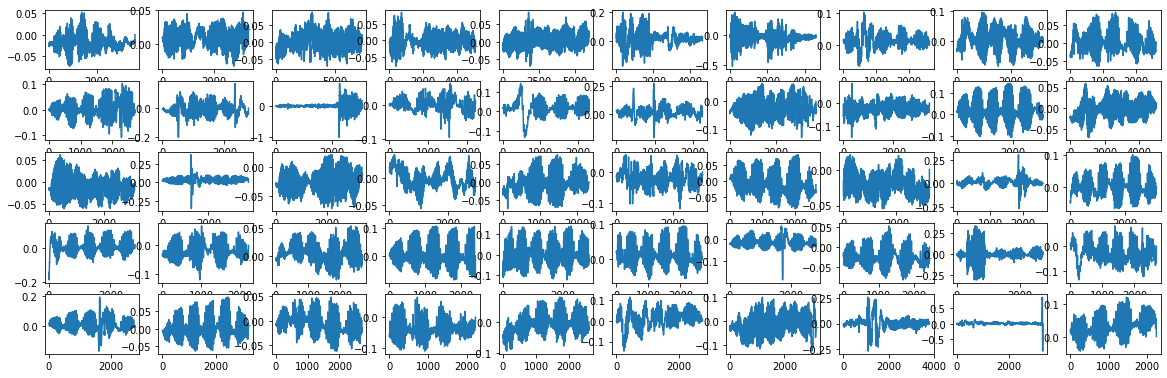

In [199]:
sylls = df_subset.raw_audio.values

nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

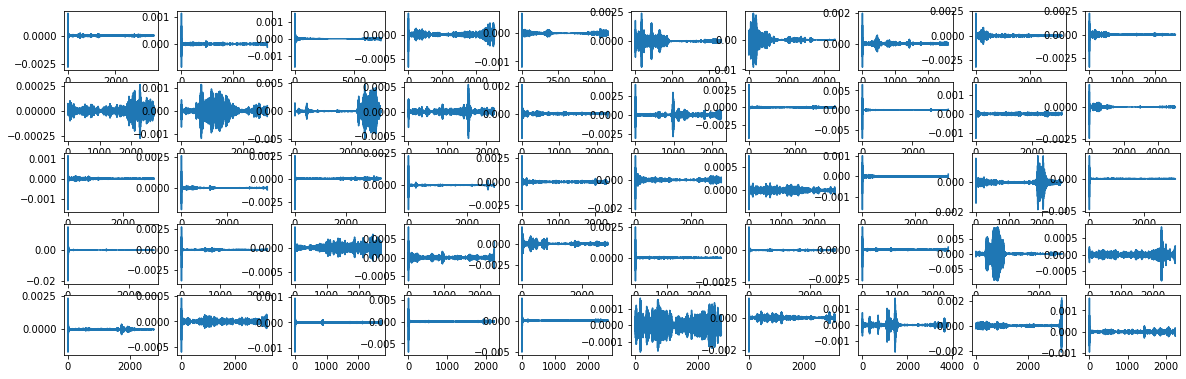

In [200]:
sylls = df_subset.audio.values

nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

**Noise reduction seems to have removed the actual call signal?**

In [0]:
df.to_pickle(PROJECT_PATH+"df_all")

In [0]:
df = pd.read_pickle(PROJECT_PATH+"df_all")

#### Spectrogramming

In [0]:
spectrograms = df.apply(lambda row: generate_mel_spectrogram(row['raw_audio'], 
                                                             row['samplerate_hz'], 
                                                             N_MELS, 
                                                             WINDOW, 
                                                             FFT_WIN , 
                                                             FFT_HOP), 
                        axis=1)

df['spectrograms'] = spectrograms

Visualize the first 50 spectrograms

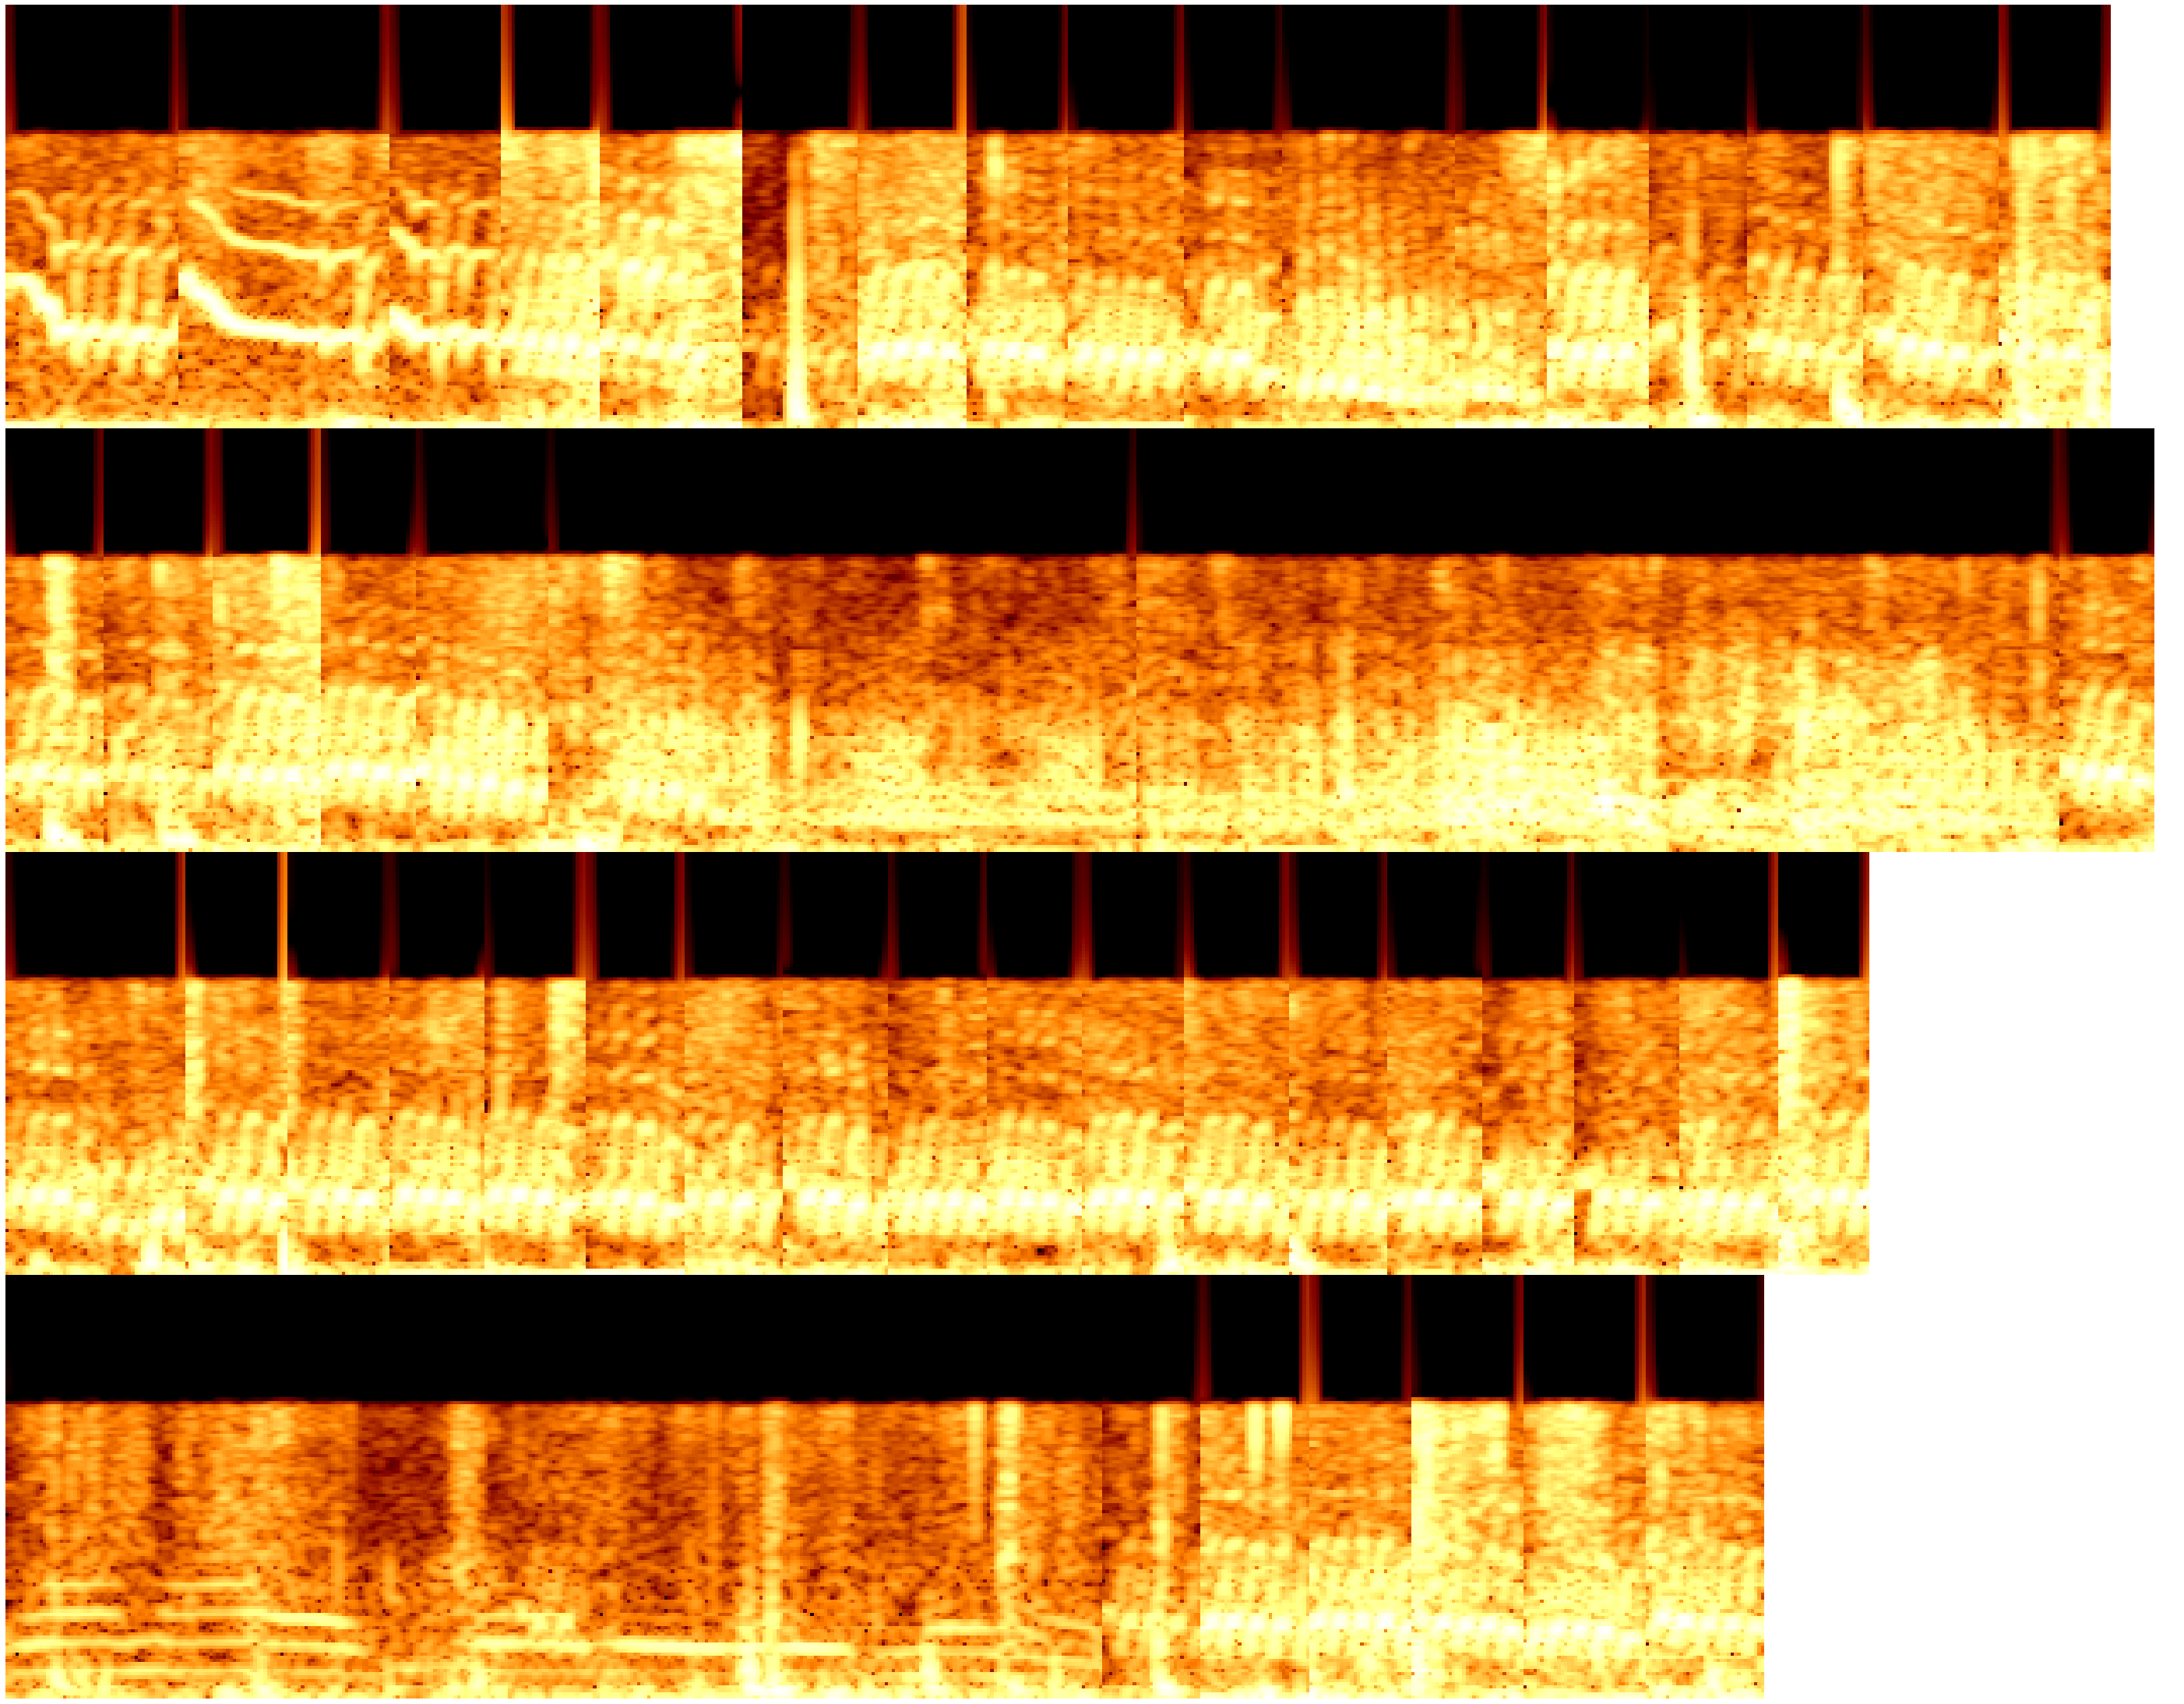

In [61]:
df_subset = df.iloc[1:50,]
specs = df_subset.spectrograms.values
draw_spec_set(specs, zoom=10, maxrows=10, colsize=5)
plt.show()

**Try with the noise reduced and filtered audios:**

In [0]:
spectrograms_nr = df.apply(lambda row: generate_mel_spectrogram(row['audio'], 
                                                                row['samplerate_hz'], 
                                                                N_MELS, 
                                                                WINDOW, 
                                                                FFT_WIN , 
                                                                FFT_HOP), 
                           axis=1)

df['spectrograms_nr'] = spectrograms_nr

In [0]:
df['spectrograms_nr'] = spectrograms_nr

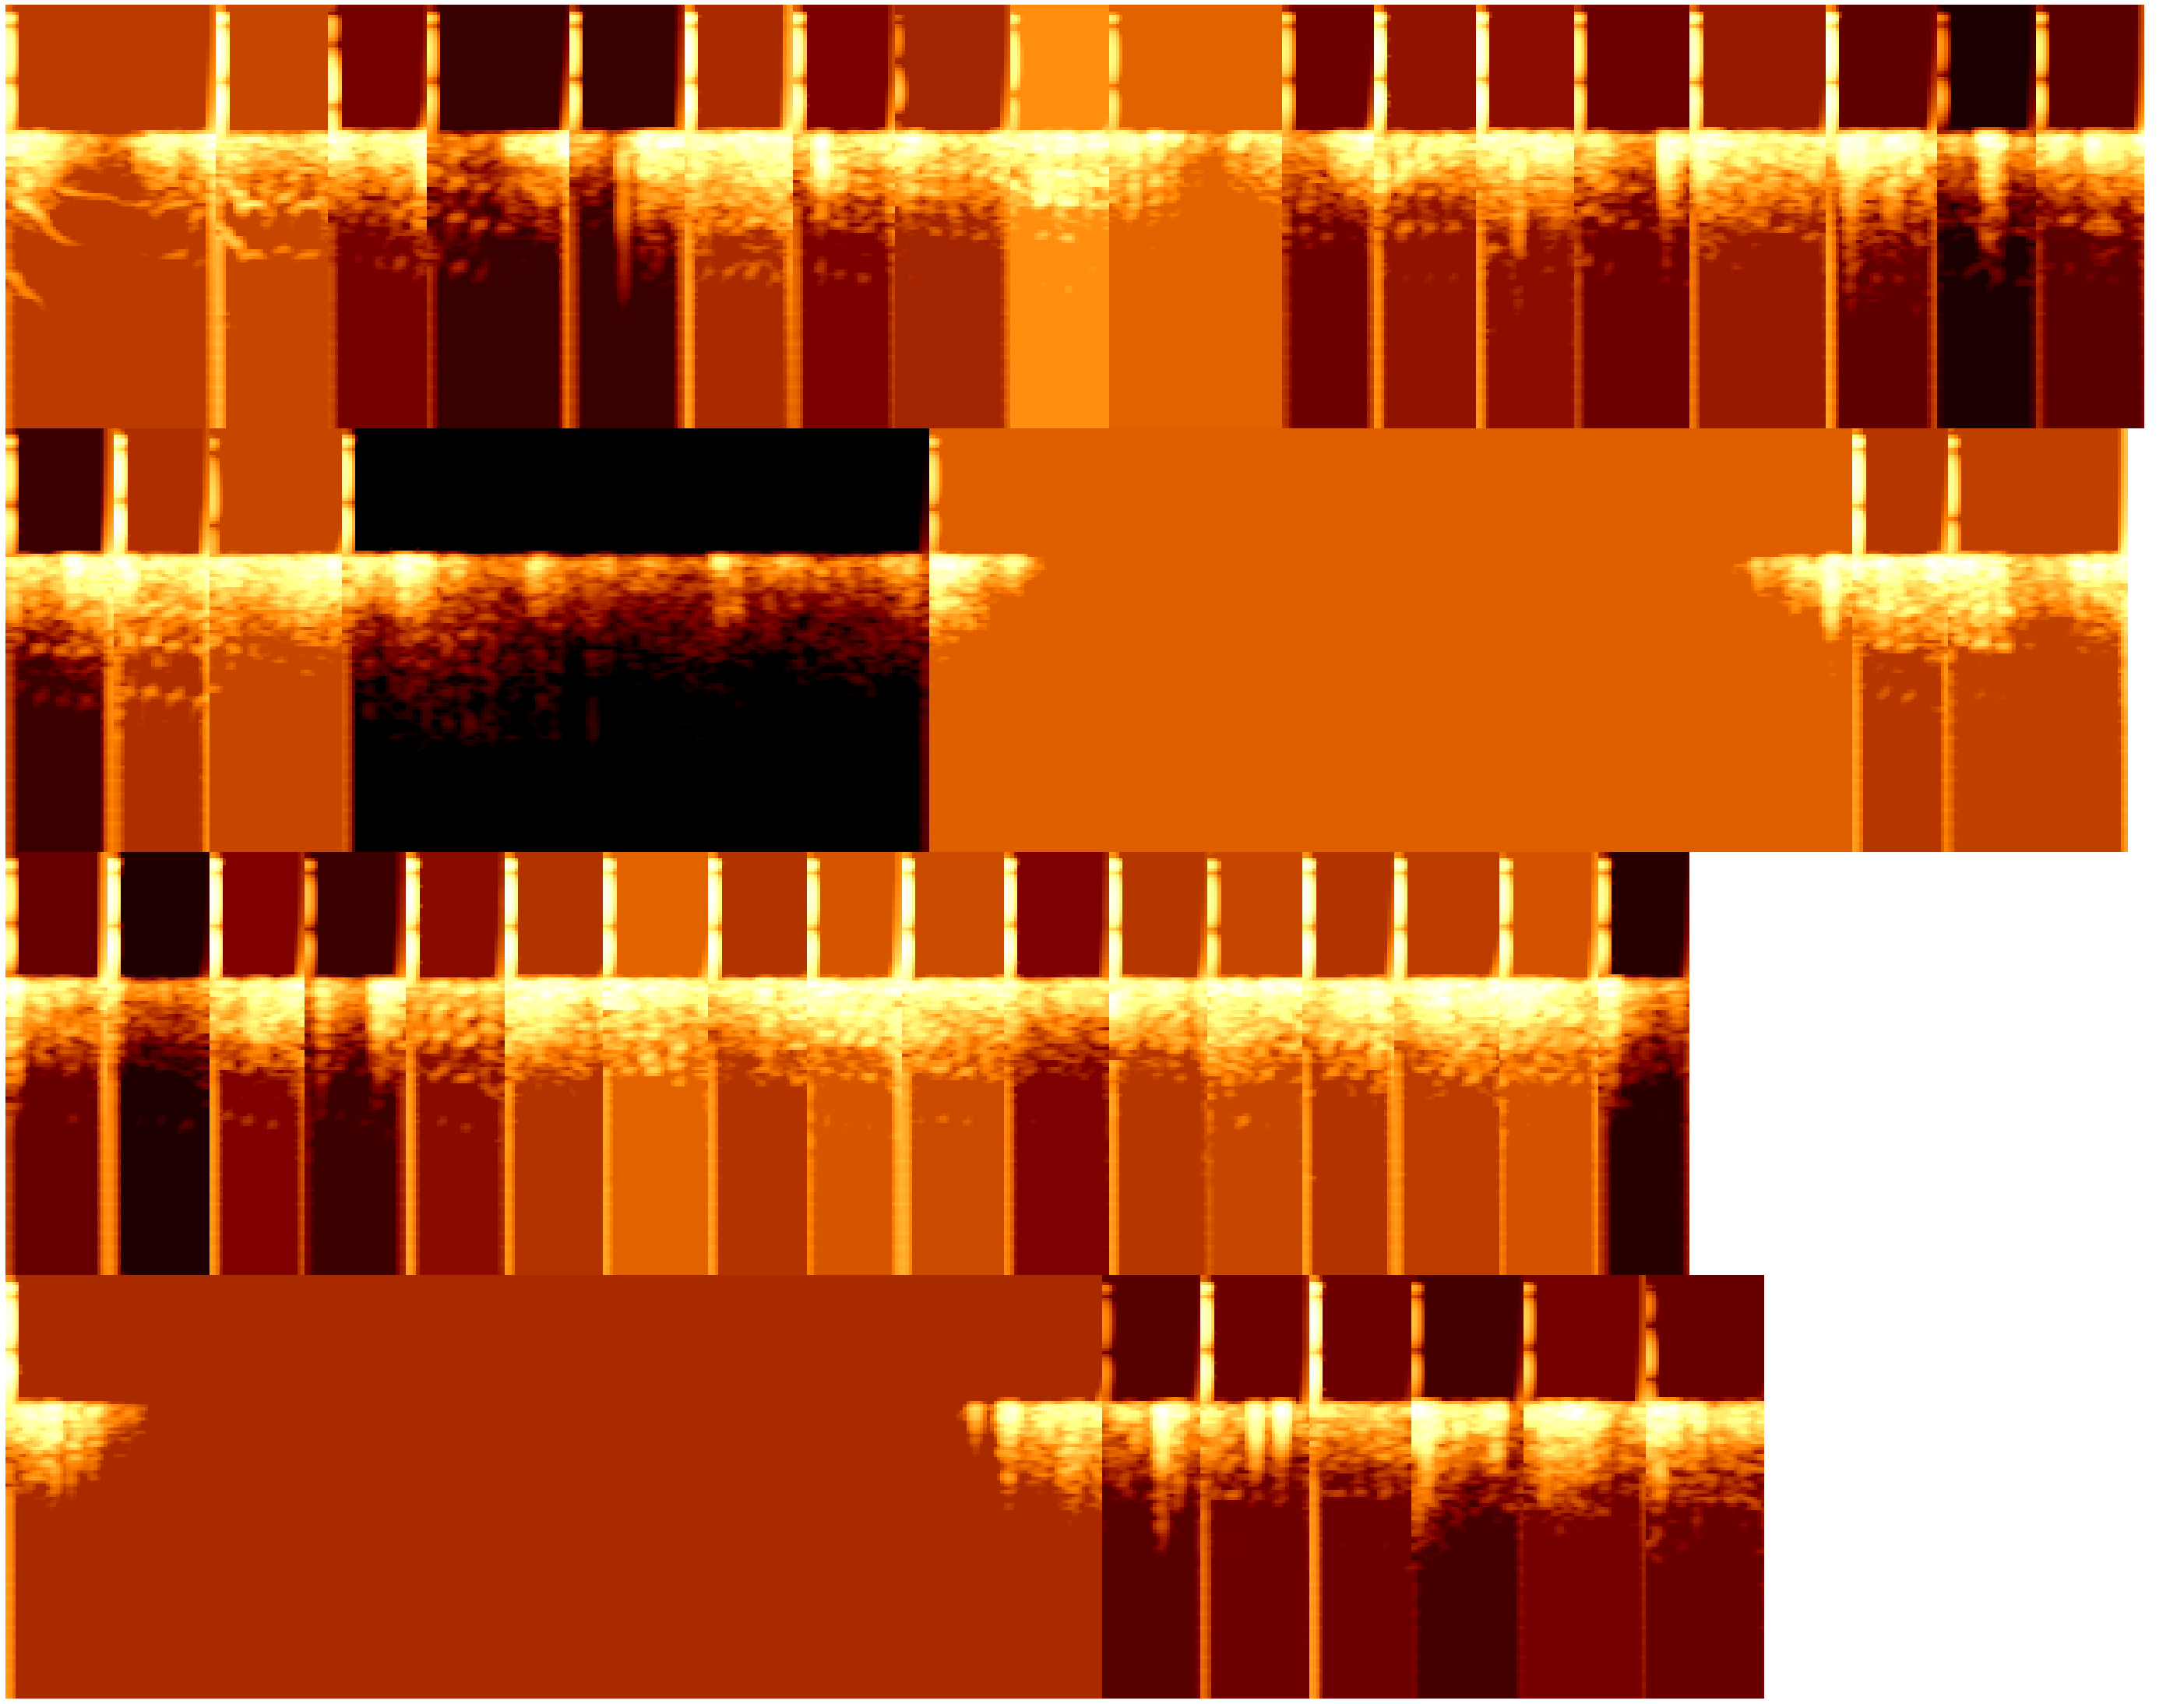

In [69]:
df_subset = df.iloc[1:50,]
specs = df_subset.spectrograms_nr.values
draw_spec_set(specs, zoom=10, maxrows=10, colsize=5)
plt.show()

Nope.

# Code-Reste

### Checking what files are present

In [46]:
jsons = os.listdir(JSON_OUT)
audios = os.listdir(AUDIO_OUT)

print(len(jsons))
print(len(audios))

print(jsons[4])
print(audios[4])

#jsons = [os.path.basename(json)[:-5] for json in jsons]
#audios = [os.path.basename(audio)[:-4] for audio in audios]

jsons = [os.path.basename(json).split('.')[0] for json in jsons]
audios = [os.path.basename(audio).split('.')[0] for audio in audios]


print(jsons[4])
print(audios[4])


diffs = pd.Series(list(set(audios).difference(list(set(jsons)))))
print("In audios, but not in jsons:"+str(diffs.size))

diffs = pd.Series(list(set(jsons).difference(list(set(audios)))))
print("In jsons, but not in audios:"+str(diffs.size))

2671
2671
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call58.JSON
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call31.wav
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call58
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call31
In audios, but not in jsons:0
In jsons, but not in audios:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [47]:
print(len(jsons))
print(len(list(set(jsons))))


print(len(audios))
print(len(list(set(audios))))

2671
2671
2671
2671


In [27]:
print(diffs.values)

['HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav']


In [40]:
glob.glob(AUDIO_OUT+'HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav')

['/content/drive/My Drive/meerkat/segmented_audios/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav']

In [43]:
glob.glob(JSON_OUT+'HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20*')

['/content/drive/My Drive/meerkat/json_files/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.JSON',
 '/content/drive/My Drive/meerkat/json_files/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav.JSON']

In [37]:
audios = os.listdir(AUDIO_OUT)
print(len(audios))
print(len(list(set(audios))))

2671
2671


In [34]:
audios.count('HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav')

1

In [0]:
os.remove('/content/drive/My Drive/meerkat/json_files/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav.JSON')

In [0]:
# Checking which files are uploaded and which aren't even though they should have been

years = ['2017', '2019']

for year in years:
  print("Year is: "+year)
  matching = pd.read_csv(PROJECT_PATH+"/matching_"+year+".txt", sep="\t", header=None)
  matching.columns = ['name', 'wav', 'csv']

  print(matching.shape)
  matching = matching.dropna()
  print("After dropping NA:")
  print(matching.shape)

  wavs_file = [os.path.basename(x) for x in matching['wav']]
  if(year=='2017'):
    audio_dir = AUDIO_IN
  elif(year=='2019'):
    audio_dir = PROJECT_PATH+'matched_wavs_2019'
  
  wavs_drive = os.listdir(audio_dir)

  if(len(set(wavs_drive))==len(wavs_drive)):
    print("No duplicates")
  else:
    print("Duplicates!")

  diffs = pd.Series(list(set(wavs_drive).difference(set(wavs_file))))
  print("In drive, but not in file:"+str(diffs.size))
  print(diffs)

  diffs = pd.Series(list(set(wavs_file).difference(set(wavs_drive))))
  print("In file, but not in drive:"+str(diffs.size))
  print(diffs)
  diffs.to_csv(PROJECT_PATH+'diffs'+year+'.csv', sep=";")


Year is: 2017
(51, 3)
After dropping NA:
(45, 3)
No duplicates
In drive, but not in file:0
Series([], dtype: float64)
In file, but not in drive:0
Series([], dtype: float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Year is: 2019
(65, 3)
After dropping NA:
(65, 3)
No duplicates
In drive, but not in file:0
Series([], dtype: float64)
In file, but not in drive:0
Series([], dtype: float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


### Moving files into different folders

In [0]:
os.chdir(PROJECT_PATH)

In [0]:
print(len(os.listdir("in_wavs")))
print(len(os.listdir("matched_wavs_2019")))

In [0]:
# move all files from matched_wavs_2019 into in_wavs
files2move = os.listdir("matched_wavs_2019")
for f in files2move:
  shutil.move(PROJECT_PATH+'matched_wavs_2019/'+f, 'in_wavs')

os.rmdir(PROJECT_PATH+'matched_wavs_2019')

### Removing bad quality

Should remove all files that are not usable for the analysis because later steps in the preprocessing are not written to handle missing files that are usually created during preprocessing.

Need to remove those with low quality, these are:
- HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163
- HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052

as well as the one without calls, which was:

- HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110

In [0]:
files2delete = ['HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163', 
                'HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052',
                'HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110']
                
# Removing segmented audios
for file in files2delete:
  fileList = glob.glob(AUDIO_OUT+file+'*.wav')
 # Iterate over the list of filepaths & remove each file.
  for filePath in fileList:
      try:
          os.remove(filePath)
      except:
          print("Error while deleting file : ", filePath)
          
print("Remaining: "+str(len(glob.glob(AUDIO_OUT+'*')))+" audio chunks")

# Removing labels files and audio in files
for file in files2delete:
  try:
    os.remove(LABELS_OUT+file+'_labels.csv')
  except:
    print("Error while deleting file csv for : ", file)
  try:
    os.remove(AUDIO_IN+file+'.wav')
  except:
    print("Error while deleting wav for file : ", file)

### Other

In [0]:
# just a sanity check
for wav, label in zip(wav_filepathList, csv_filepathList):
  fileID = os.path.basename(wav).replace('.wav','')
  numfiles=len(glob.glob(AUDIO_OUT+fileID+'*.wav'))
  label_table = pd.read_csv(label)
  numlabels = label_table.shape[0]
  print(str(numfiles)+' : '+str(numlabels))

In [0]:
from avgn.utils.json import  NoIndentEncoder
from avgn.utils.audio import get_samplerate
import json
from avgn.utils.paths import DATA_DIR
import avgn

In [0]:
DATASET_ID = 'meerkat'
SPECIES = "Suricata suricatta"

def generate_json(call_filepath, audio_filepath, label_filepath):
    wav_duration = librosa.get_duration(filename=call_filepath)
    wavdate = datetime(year=int(row.year), day=int(row.day), month = int(row.month))
    wav_date = wavdate.strftime("%Y-%m-%d_%H-%M-%S")
    
    # wav samplerate and duration
    sr = get_samplerate(row.wav_loc.as_posix())
    wav_duration = librosa.get_duration(filename=row.wav_loc)
    
    # wav general information
    json_dict = {}
    json_dict["datetime"] = wav_date
    json_dict["samplerate_hz"] = sr
    json_dict["samplerate_hz"] = sr
    json_dict["length_s"] = wav_duration
    json_dict["species"] = "Suricata suricatta"
    json_dict["common_name"] = "Meerkat"
    json_dict["wav_loc"] = row.wav_loc.as_posix()
        json_dict = {}
    json_dict["bout_number"] = 
    json_dict["original_wav"] = bout_df.wav_loc.values[0].as_posix()
    json_dict["noise_loc"] = noise_out.as_posix()
    json_dict["indv"] = 
    
    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    json_out = JSON_OUT+(row.wav_loc.stem + ".JSON")

    # save json
    print(json_txt, file=open(json_out, "w"))

Example for a single file

Do the process first with a single file, just taking a random example file.


In [0]:
label_filename = "HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163_label.CSV"
label_filepath = LABELS_IN+label_filename

audio_filename = "HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163.wav"
audio_filepath = AUDIO_IN+audio_filename

Generate the chunks:

In [0]:
generate_audio_chunks(audio_filepath, label_filepath)

Processing HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163.wav
Parsing...
Chunking...


Looking at results:

In [0]:
durations = [librosa.get_duration(filename=myfile) for myfile in glob.glob("*.wav")]
statistics.mean(durations)
plt.hist(durations)
#print(durations.index(max(durations)))
#print(durations[160])
#print(max(durations))
#y, sr = librosa.load("HM_HMB_R11_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221163_call160.wav", sr=None)
#Audio(y, rate=sr)

In [0]:
# Function that adds start and stop times in milliseconds as additional columns
# to a dataframe containing start time and duration in format 
# h:min:s:ms (column 'Start') and min:s:ms (column 'Duration')
# Input: labels dataframe (Pandas dataframe)
# Output: labels dataframe with additional columns 'start_ms' and
#         'stop_ms' (Pandas dataframe)
# Example usage: labels = add_startstop_ms(labels)

def add_startstop_ms(labels):
  
  if (labels.shape[0]!=0):
  
    # Start
    start = labels.Start.str.split(":", expand=True)
    start.columns = ['h', 'min', 's']
    start = pd.concat([start.drop(columns="s"),start.s.str.split(".", expand=True)], axis=1)

    start.columns = ['h', 'min', 's', 'ms']
    for i in list(start): start[i] = start[i].astype(str).astype(int)

    start['total']= start.apply(lambda row: (row['h']*60*60*1000+ 
                              row['min']*60*1000+ row['s']*1000+row['ms']), axis = 1)
  
    duration = labels.Duration.str.split(":", expand=True)
    duration.columns = ['min', 's']
    duration = pd.concat([duration.drop(columns="s"),duration.s.str.split(".", expand=True)], axis=1)

    duration.columns = ['min', 's', 'ms']
    for i in list(duration): duration[i] = duration[i].astype(str).astype(int)

    duration['total']= duration.apply(lambda row: (row['min']*60*1000+ 
                                               row['s']*1000+row['ms']), axis = 1)

    labels['start_ms']=start['total']
    labels['stop_ms']=start['total']+duration['total']

  return labels

### Removing files:

In [0]:
os.chdir(JSON_OUT)

In [133]:
len(os.listdir())

0

In [0]:
#fileList = glob.glob('*_call*.wav')
fileList = glob.glob('*.JSON')
 # Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Next, I remove irrelevant rows, i.e. those that mark start, end, synch, beep or are marked as noise:

In [0]:
irrelevant = ['SYNCH', 'START', 'END', 'NOISE', 'BEEP']
irrelevant=irrelevant+[item.lower() for item in irrelevant]

# relevant labels
labels = labels[~labels['Name'].str.contains('|'.join(irrelevant))]

False

In [0]:
# Start
start = labels.Start.str.split(":", expand=True)
start.columns = ['h', 'min', 's']
start = pd.concat([start.drop(columns="s"),start.s.str.split(".", expand=True)], axis=1)

start.columns = ['h', 'min', 's', 'ms']
for i in list(start): start[i] = start[i].astype(str).astype(int)

start['total']= start.apply(lambda row: (row['h']*60*60*1000+ 
                     row['min']*60*1000+ row['s']*1000+row['ms']), axis = 1)

In [0]:
# Call duration
duration = labels.Duration.str.split(":", expand=True)
duration.columns = ['min', 's']
duration = pd.concat([duration.drop(columns="s"),duration.s.str.split(".", expand=True)], axis=1)

duration.columns = ['min', 's', 'ms']
for i in list(duration): duration[i] = duration[i].astype(str).astype(int)

duration['total']= duration.apply(lambda row: (row['min']*60*1000+ 
                                               row['s']*1000+row['ms']), axis = 1)

In [0]:
# Add start and stop ms to labels table
labels['start_ms']=start['total']
labels['stop_ms']=start['total']+duration['total']

The start and stop times in ms are now in the labels table (start_ms, stop_ms).

In [0]:
labels

Now, I can chunk the audio file according to these start and stop times. This will create new, very short audio files.

In [0]:
%cd segmented_audios

In [0]:
audio = AudioSegment.from_wav(audio_filepath)
chunks = labels.apply(lambda row: (audio[row['start_ms']:row['stop_ms']]), axis = 1)

chunks.index=range(chunks.shape[0])

for index, content in chunks.items():
    content.export((audio_filename[:-4]+"_call"+str(index)+".wav"), format="wav")

In [0]:
# Function to get list of call files to a given file ID
# Input: file ID (String)
# Output: List of paths to wav call files(List of Strings)
# Example use: get_call_filepaths('HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102.wav')

def get_call_filepaths(fileID):
  wav_filename = os.path.splitext(os.path.basename(wav_file))[0]
  call_filepathList = glob.glob(AUDIO_OUT+file_ID+'*.wav')
  return call_filepathList